## Load data

In [1]:
# Load the page metadatas
import json
import re
import pandas as pd
import os
import csv

from typing import List

from typing import TypedDict
#from langchain import hub
from langchain.chat_models import init_chat_model
from langchain.document_loaders import PyPDFLoader
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

from langgraph.graph import START, StateGraph
from langchain_huggingface import HuggingFacePipeline
from langchain_text_splitters import RecursiveCharacterTextSplitter

from sentence_transformers import CrossEncoder
from rank_bm25 import BM25Okapi

import pickle
import transformers
import torch
import tqdm
import yaml


def map_page_to_section(metadata):
    page_map = {}
    for section, sec_data in metadata.items():
        sec_start = sec_data.get("page_start")
        sec_end = sec_data.get("page_end")
        subsections = sec_data.get("subsections", {})
        for page in range(sec_start, sec_end + 1):
            page_map[page] = {"section": section, "subsection": None}
        for subsec, subsec_data in subsections.items():
            sub_start = subsec_data.get("page_start")
            sub_end = subsec_data.get("page_end")
            for page in range(sub_start, sub_end + 1):
                page_map[page] = {"section": section, "subsection": subsec}
                
    return page_map


def read_pdf_pages(pdf_path: str) -> List[str]:
    """
    Read a PDF and return a list of page texts (one string per page) using PyPDFLoader.
    """
    loader = PyPDFLoader(pdf_path)
    docs = loader.load()  # returns a list of Document objects, typically one per page
    return [doc.page_content for doc in docs]


with open("exps/fixed_chunking.yml", "r") as f:
    config = yaml.safe_load(f)
    
exists_semantic_vs = os.path.exists(config["semantic_vs_path"])

if not exists_semantic_vs:
    with open("data/book-metadata.json", "r") as f:
        book_metadata = json.load(f)

    page_to_section = map_page_to_section(book_metadata)
    pages = read_pdf_pages("data/book.pdf")
    BOOK_PAGE_OFFSET = 18
    BOOK_LAST_PAGE = 640
    pages = pages[BOOK_PAGE_OFFSET:BOOK_LAST_PAGE]

/home/julio/Apps/miniconda3/envs/casml4/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Indexers Population

In [ ]:
%reload_ext autoreload
%autoreload 2
from chunking import *


# Keyword vector store
class BM25:

    def __init__(self, docs: List[Document]):
        self.docs = docs
        tokenized_corpus = [doc.page_content.lower().split(" ") for doc in docs]
        self.bm25 = BM25Okapi(tokenized_corpus)

    def similarity_search_with_relevance_scores(self, query, k=4):
        tokenized_query = query.lower().split(" ")
        scores = self.bm25.get_scores(tokenized_query)
        top_k_idx = scores.argsort()[::-1][:k]
        return [(self.docs[i], scores[i]) for i in top_k_idx]
    

# Create vector store
model_kwargs = {"device":"cpu"}
embedding_model_name = "sentence-transformers/all-mpnet-base-v2"

embeddings = HuggingFaceEmbeddings(model_name=embedding_model_name, model_kwargs=model_kwargs, 
                                  encode_kwargs={'normalize_embeddings':True})

semantic_vs = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory=config["semantic_vs_path"]
)


if not exists_semantic_vs:
    chunking_fn = get_chunking_fn(config["chunking"])
    docs = chunking_fn(page_to_section, pages)

    semantic_vs.add_documents(docs)
    keyword_vs = BM25(docs)
    
    pickle.dump(keyword_vs, open(config["keyword_vs_fname"], "wb"))
else:
    keyword_vs = pickle.load(open(config["keyword_vs_fname"], "rb"))

## Pipeline Definition

In [ ]:
%reload_ext autoreload
%autoreload 2
from retrieval import HybridRetriever

def get_llm():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    model_id = "Qwen/Qwen2.5-0.5B-Instruct"
 
    def load_model_and_tokenizer(model_id):
        model_config = transformers.AutoConfig.from_pretrained(model_id)
        model = transformers.AutoModelForCausalLM.from_pretrained(
            model_id,
            trust_remote_code=True,
            config=model_config,
            device_map="auto",  # Automatically distribute the model across available devices
        )
        tokenizer = transformers.AutoTokenizer.from_pretrained(model_id)
        
        return model, tokenizer

    model, tokenizer = load_model_and_tokenizer(model_id)

    # Create the query pipeline
    query_pipeline = transformers.pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        torch_dtype=torch.float16, 
        max_new_tokens=1000, 
        device_map="auto", 
        num_return_sequences=1,
        truncation=True,
        do_sample=True,  
        temperature=0.2,  
        pad_token_id=tokenizer.eos_token_id  
    )

    # Using the the HuggingFacePipeline class from LangChain to wrap the pipeline
    return HuggingFacePipeline(pipeline=query_pipeline)


# Initialize LLM
llm = get_llm()

hybrid_retriever = HybridRetriever(
    semantic_vs=semantic_vs,
    keyword_vs=keyword_vs,
    llm = llm
)

# Define state
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    sections: List[str] 
    page_nums: List[int]


# Define application steps
def retrieve(state: State):
    docs_and_relevance = hybrid_retriever.retrieve(state["question"], top_k=config["top_k"]*4)
    reranked_docs = hybrid_retriever.rerank(state["question"], docs_and_relevance, top_k=config["top_k"])

    return {"context": reranked_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    sections = [doc.metadata.get("sections", "") for doc in state["context"]]
    page_nums = [doc.metadata.get("page_num", -1) for doc in state["context"]]

    prompt = create_query_prompt(state["question"], docs_content)
    response = llm.invoke(prompt)
    
    # Remove prompt from response #TODO: Enhance without including the context.
    response = response[len(prompt):].strip()
    
    return {
            "answer": response,
            "sections": sections,
            "page_nums": page_nums,
            "context": docs_content
            }


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")

graph = graph_builder.compile()

Some parameters are on the meta device because they were offloaded to the cpu.
Device set to use cuda:0


## Post-processing and Submission File Creation

In [7]:
# Post-processing
def clean_answer(answer):
    answer = re.sub("\**", "", answer)
    return re.sub("##*", "", answer)


# Read queries from data/queries.json and query to the RAG system
def create_submission(graph):
    with open("data/queries.json", "r") as f:
        queries = json.load(f)

    submission_fname = config['out_fname']
    with open(submission_fname, "w") as f:
        f.write("ID,context,answer,references\n")

    for i in tqdm.tqdm(range(len(queries))):
        response = graph.invoke({"question": queries[i]['question']})

        with open(submission_fname, "a") as f:
            distinct_refs = list({(s, p) for s, p in zip(response["sections"], response["page_nums"])})
            
            row = [queries[i]['query_id'],
                response["context"],
                clean_answer(response["answer"]),
                {"sections": [s for s, _ in distinct_refs],
                "page_nums": [p for _, p in distinct_refs]}]
            
            writer = csv.writer(f)
            writer.writerow(row)

        
create_submission(graph)

<>:3: SyntaxWarning: invalid escape sequence '\*'
<>:3: SyntaxWarning: invalid escape sequence '\*'
/tmp/ipykernel_880934/2846775883.py:3: SyntaxWarning: invalid escape sequence '\*'
  answer = re.sub("\**", "", answer)
  0%|          | 0/50 [00:18<?, ?it/s]


AttributeError: 'tuple' object has no attribute 'page_content'

## Results Visualization

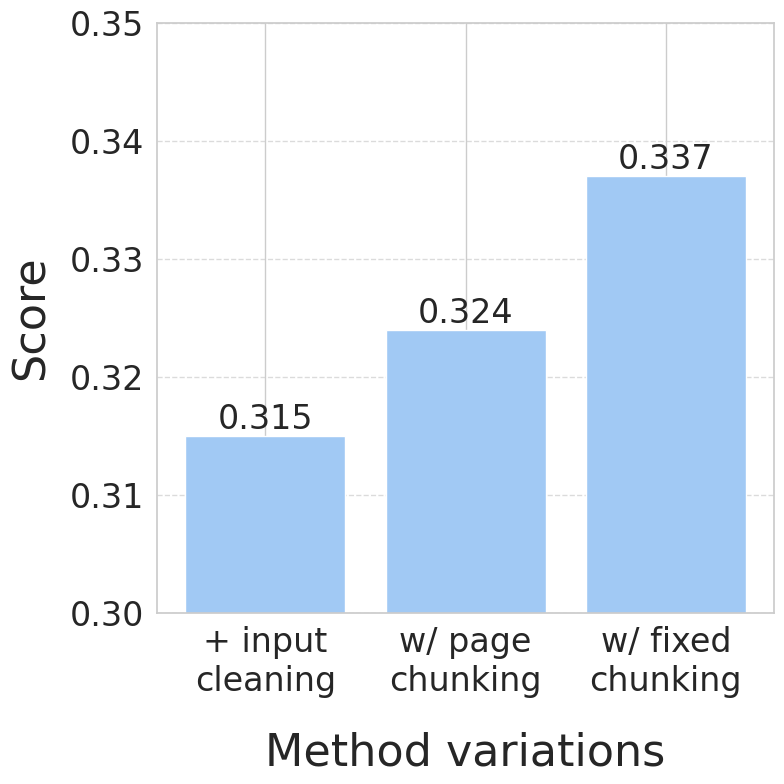

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")

labels = ["+ input\ncleaning", "w/ page\nchunking", "w/ fixed\nchunking"]
title = "Chunking methods"
scores = [0.315, 0.324, 0.337]

# Create figure with appropriate size
plt.figure(figsize=(8, 8))

# Create bar plot
bars = plt.bar(labels, scores)

# Customize the plot
plt.ylabel('Score', fontsize=32, labelpad=12)
plt.xlabel('Method variations', fontsize=32, labelpad=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set y-axis range
plt.ylim(0.3, 0.35)

# Set y-ticks to 4 evenly spaced labels
plt.yticks(np.linspace(0.3, 0.35, 6))

# Add value labels on top of each bar with larger font size
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom', fontsize=24)

# Adjust layout to prevent label cutoff
plt.tight_layout()